In [15]:
import os
import kagglehub
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

path = kagglehub.dataset_download("jamiewelsh2/nba-player-salaries-2022-23-season")
print("Path to dataset files:", path)

print("Files in dataset folder:")
for f in os.listdir(path):
    print("  ", f)

csv_path = os.path.join(path, "nba_2022-23_all_stats_with_salary.csv")
df = pd.read_csv(csv_path)

print("\nColumns in dataset:")
print(df.columns.tolist())

Using Colab cache for faster access to the 'nba-player-salaries-2022-23-season' dataset.
Path to dataset files: /kaggle/input/nba-player-salaries-2022-23-season
Files in dataset folder:
   nba_salaries.csv
   nba_2022-23_all_stats_with_salary.csv

Columns in dataset:
['Unnamed: 0', 'Player Name', 'Salary', 'Position', 'Age', 'Team', 'GP', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Total Minutes', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']


In [16]:
# --Cleaning--
df = df.drop_duplicates()

# Remove players with very few games played
if "GP" in df.columns:
    df = df[df["GP"] >= 10]

# Replace NA shooting percentages and similar with 0
df = df.fillna(0)

# Make sure Salary is numeric
df["Salary"] = pd.to_numeric(df["Salary"], errors="coerce")

# Drop rows where Salary is missing
df = df.dropna(subset=["Salary"])

# Optional: log-transform salary to help with skew
df["log_salary"] = np.log1p(df["Salary"])


Using feature columns:
['Age', 'GP', 'GS', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'FG%', '3P%', 'FT%']

Test RMSE: $5,406,043
Test R^2: 0.790

Five players with largest absolute salary prediction error:
       Player Name Team Position    Salary  PredictedSalary      AbsError
26  Andrew Wiggins  GSW       SF  33616770     1.316109e+07  2.045568e+07
46      Al Horford  BOS        C  26500000     1.245950e+07  1.404050e+07
15    Jimmy Butler  MIA       PF  37653300     2.584470e+07  1.180860e+07
78   Collin Sexton  UTA       PG  16700000     5.538814e+06  1.116119e+07
85      Tyus Jones  MEM       PG  15000000     4.142686e+06  1.085731e+07


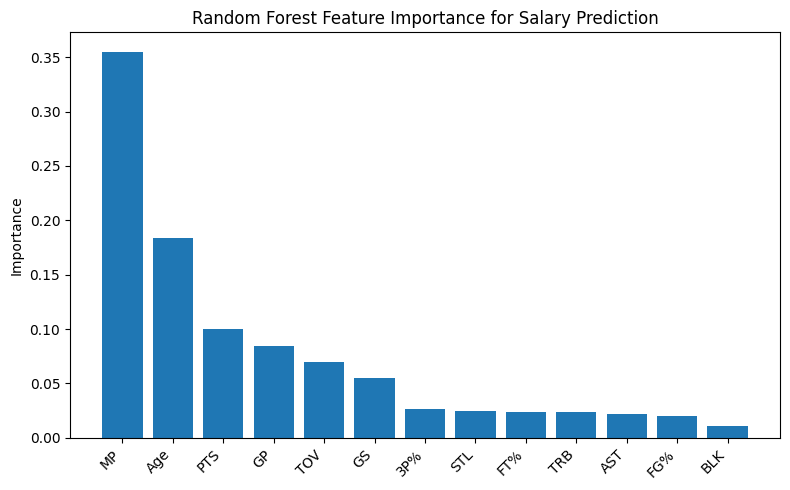

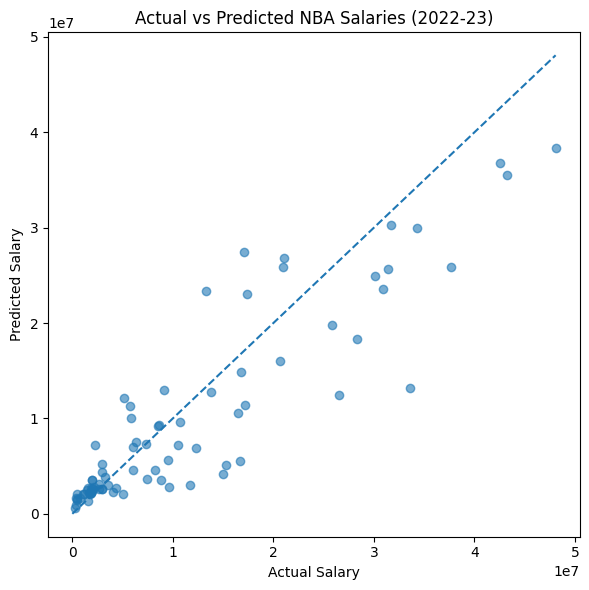


Summary performance table:
  Metric         Value
0   RMSE  5.406043e+06
1    R^2  7.898620e-01


In [17]:
# --Define features and label--

# Candidate feature columns
candidate_features = [
    "Age", "GP", "GS", "MP",
    "PTS", "TRB", "AST", "STL", "BLK", "TOV",
    "FG%", "3P%", "FT%"
]

feature_cols = [c for c in candidate_features if c in df.columns]
print("\nUsing feature columns:")
print(feature_cols)

X = df[feature_cols].copy()
y = df["log_salary"]  # using log of salary as the prediction target

# --Train-test split--
X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
    X, y, df, test_size=0.2, random_state=42
)

# --Train model-- (Random Forest)
rf = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    n_jobs=-1,
)
rf.fit(X_train, y_train)

# --Evaluate model--
y_pred_log = rf.predict(X_test)

# Convert log predictions back to salary dollars:
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred_log)

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2 = r2_score(y_test_actual, y_pred_actual)

print(f"\nTest RMSE: ${rmse:,.0f}")
print(f"Test R^2: {r2:.3f}")

# --Attach predictions to players & find worst 5--
results = df_test.copy()
results["PredictedSalary"] = y_pred_actual
results["Error"] = results["Salary"] - results["PredictedSalary"]
results["AbsError"] = results["Error"].abs()

# Sort by absolute error, descending
worst5 = results.sort_values("AbsError", ascending=False).head(5)

print("\nFive players with largest absolute salary prediction error:")
print(results.loc[worst5.index, ["Player Name", "Team", "Position", "Salary", "PredictedSalary", "AbsError"]])

# --Feature importance plot--
importances = rf.feature_importances_
fi_df = pd.DataFrame({"feature": feature_cols, "importance": importances})
fi_df = fi_df.sort_values("importance", ascending=False)

plt.figure(figsize=(8, 5))
plt.bar(fi_df["feature"], fi_df["importance"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importance for Salary Prediction")
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=150)
plt.show()

# --Actual vs predicted scatter plot--
plt.figure(figsize=(6, 6))
plt.scatter(y_test_actual, y_pred_actual, alpha=0.6)
max_val = max(y_test_actual.max(), y_pred_actual.max())
plt.plot([0, max_val], [0, max_val], linestyle="--")
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs Predicted NBA Salaries (2022-23)")
plt.tight_layout()
plt.savefig("actual_vs_predicted.png", dpi=150)
plt.show()

# --Simple table of summary stats--
summary_table = pd.DataFrame({
    "Metric": ["RMSE", "R^2"],
    "Value": [rmse, r2]
})
print("\nSummary performance table:")
print(summary_table)
summary_table.to_csv("model_performance_summary.csv", index=False)